In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
from datetime import datetime, timedelta, date

In [ ]:
import plotly.offline as pyoff
import plotly.graph_objs as go

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Sales prediction:
- data wrangling
- data transformation
- build LSTM model & evaluation

# Data
- https://www.kaggle.com/c/demand-forecasting-kernels-only
- given 5 years of sales for 50 different items at 10 different stores
- predict 3 months of sales for those

In [ ]:
# sales_df
sales_df = pd.read_csv('data/demand-forecasting-kernels-only/train.csv')
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
# sales_test_df
sales_test_df = pd.read_csv('data/demand-forecasting-kernels-only/test.csv')
sales_test_df['date'] = pd.to_datetime(sales_test_df['date'])
sales_test_df = sales_test_df.drop('id', axis=1)
sales_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    45000 non-null  datetime64[ns]
 1   store   45000 non-null  int64         
 2   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.0 MB


In [ ]:
sales_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
print('sales_df has {} rows and {} columns'.format(sales_df.shape[0], sales_df.shape[1]))

sales_df has 913000 rows and 4 columns


In [ ]:
# describe 'date'
sales_df['date'].describe()

count                  913000
unique                   1826
top       2017-07-04 00:00:00
freq                      500
first     2013-01-01 00:00:00
last      2017-12-31 00:00:00
Name: date, dtype: object

In [ ]:
# number of stores and items
print('number of stores: {}'.format(sales_df['store'].nunique()))
print('number of items at each store:')
print(sales_df.groupby('store')['item'].nunique())

number of stores: 10
number of items at each store:
store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


# Data wrangling
- aggregate data at monthly level

In [ ]:
# create 'month' as its first day
sales_df['date'] = sales_df['date'].dt.year.astype('str') + '-' + sales_df['date'].dt.month.astype('str') + '-01'
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df = sales_df.rename(columns={'date': 'month'})
sales_df.head()

,month,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,1,11
2,2013-01-01,1,1,14
3,2013-01-01,1,1,13
4,2013-01-01,1,1,10


In [ ]:
# aggregate monthly sales (for all stores and items)
sales_df = sales_df.groupby('month')['sales'].sum()
sales_df = sales_df.reset_index()
sales_df.head()

,month,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


# Data transformation
- convert to stationary: differencing
- convert to supervised: create feature set with lags
- scale data

## Stationarity

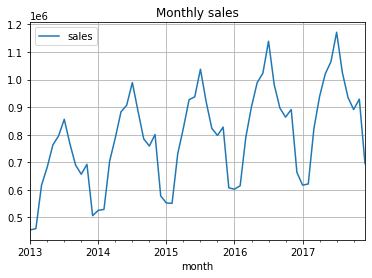

In [ ]:
# check stationarity of 'sales'
## plot: obviously not stationary
sales_df.plot(x='month', y='sales', grid=True, title='Monthly sales')
plt.show()

In [ ]:
## plot
plot_data = [
    go.Line(
        x=sales_df['month'],
        y=sales_df['sales']
    )
]

plot_layout = go.Layout(
    title='Monthly sales'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
## adfuller
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(sales_df['sales'])
df_test

(-5.247518850016353,
 7.026495391574688e-06,
 11,
 48,
 {'1%': -3.5745892596209488,
  '10%': -2.6000391840277777,
  '5%': -2.9239543084490744},
 1114.7870935545418)

In [ ]:
# get difference
## create diff_df
diff_df = sales_df.copy()

## create 'prev_sales': shift(1)
diff_df['prev_sales'] = diff_df['sales'].shift(1)
diff_df.head()

,month,sales,prev_sales
0,2013-01-01,454904,NaN
1,2013-02-01,459417,454904.0
2,2013-03-01,617382,459417.0
3,2013-04-01,682274,617382.0
4,2013-05-01,763242,682274.0


In [ ]:
## create 'diff'
diff_df['diff'] = diff_df['sales'] - diff_df['prev_sales']
diff_df.head()

,month,sales,prev_sales,diff
0,2013-01-01,454904,NaN,NaN
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0


In [ ]:
# check stationarity of 'diff'
## plot: seems stationary
plot_data = [
    go.Line(
        x=diff_df['month'],
        y=diff_df['diff']
    )
]

plot_layout = go.Layout(
    title='Monthly sales difference'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
## adfuller
df_test = adfuller(diff_df['diff'][1:])
df_test

(-1.528995981502165,
 0.5191218072432625,
 11,
 47,
 {'1%': -3.5778480370438146,
  '10%': -2.6007735310095064,
  '5%': -2.925338105429433},
 1054.1210094080243)

We will build feature set based on 'diff' - monthly sales difference

## Build feature set
- number of lags: 12

In [ ]:
# add 12 lags
for i in range(1, 13):
    field_name = 'lag_' + str(i)
    diff_df[field_name] = diff_df['diff'].shift(i)

diff_df.head()

,month,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013-01-01,454904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-01,459417,454904.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-01,617382,459417.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01,682274,617382.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-01,763242,682274.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# missing values check: we have 1 (differencing) and 12 (adding lags)
diff_df.isna().sum()

month          0
sales          0
prev_sales     1
diff           1
lag_1          2
lag_2          3
lag_3          4
lag_4          5
lag_5          6
lag_6          7
lag_7          8
lag_8          9
lag_9         10
lag_10        11
lag_11        12
lag_12        13
dtype: int64

In [ ]:
# remove missing values
diff_df = diff_df.dropna()
diff_df.head()

,month,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
13,2014-02-01,529117,525987.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
14,2014-03-01,704301,529117.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
15,2014-04-01,788914,704301.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
16,2014-05-01,882877,788914.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
17,2014-06-01,906842,882877.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


### How useful are our features for prediction?
- OLS adjusted R-squared

In [ ]:
# regression model: 'diff ~ lag_1'
import statsmodels.formula.api as smf

## regression formula
model = smf.ols(formula='diff ~ lag_1', data=diff_df)
model_fit = model.fit()

## adjusted r-squared
print('adjusted r-squared: {}'.format(model_fit.rsquared_adj))
print(model_fit.summary())

adjusted r-squared: 0.02893426930900389
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.371
Date:                Tue, 27 Oct 2020   Prob (F-statistic):              0.131
Time:                        12:30:59   Log-Likelihood:                -611.39
No. Observations:                  47   AIC:                             1227.
Df Residuals:                      45   BIC:                             1230.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

Interpretation: lag_1 explains 3% of the variation (of diff)

In [ ]:
# regression model: 'diff ~ lag_1 + lag_2 + ... + lag_6'
import statsmodels.formula.api as smf

## regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6', data=diff_df)
model_fit = model.fit()

## adjusted r-squared
print('adjusted r-squared: {}'.format(model_fit.rsquared_adj))
print(model_fit.summary())

adjusted r-squared: 0.4497268445996091
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     7.266
Date:                Tue, 27 Oct 2020   Prob (F-statistic):           2.71e-05
Time:                        12:30:59   Log-Likelihood:                -595.28
No. Observations:                  47   AIC:                             1205.
Df Residuals:                      40   BIC:                             1218.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6

Interpretation: lag_1 to lag_6 explain 45% of the variation (of diff)

In [ ]:
# regression model: 'diff ~ lag_1 + lag_2 + ... + lag_12'
import statsmodels.formula.api as smf

## regression formula
formula = 'diff ~ '
cols = diff_df.loc[:, 'lag_1':'lag_12'].columns

for col in cols[:-1]:
    formula = formula + col + ' + '

formula = formula + cols[-1]
print(formula)

model = smf.ols(formula=formula, data=diff_df)
model_fit = model.fit()

## adjusted r-squared
print('adjusted r-squared: {}'.format(model_fit.rsquared_adj))
print(model_fit.summary())

diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12
adjusted r-squared: 0.9795722233296558
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     184.8
Date:                Tue, 27 Oct 2020   Prob (F-statistic):           2.70e-27
Time:                        12:30:59   Log-Likelihood:                -514.06
No. Observations:                  47   AIC:                             1054.
Df Residuals:                      34   BIC:                             1078.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

Interpretation: lag_1 to lag_6 explain 45% of the variation (of diff) => we can confidently build model based on our feature set

## Scale data
- use MinMaxScaler with feature_range=(-1, 1)

In [ ]:
# create data_df
data_df = diff_df.drop(['month', 'sales', 'prev_sales'], axis=1)
data_df.head()

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
13,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
14,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
15,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
16,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
17,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [ ]:
print('data_df has {} rows and {} columns'.format(data_df.shape[0], data_df.shape[1]))

data_df has 47 rows and 13 columns


In [ ]:
# apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

## create data_scaled_df
data_scaled_df = data_df.copy()

## scale 'diff'
scaler_diff = MinMaxScaler(feature_range=(-1, 1))
scaler_diff = scaler_diff.fit(data_df[['diff']])
data_scaled_df['diff'] = scaler_diff.transform(data_scaled_df[['diff']])

In [ ]:
## scale lags
scaler_lags = MinMaxScaler(feature_range=(-1, 1))
scaler_lags = scaler_lags.fit(data_df.drop('diff', axis=1))
data_scaled_df.loc[:, 'lag_1':'lag_12'] = scaler_lags.transform(data_df.drop('diff', axis=1))

In [ ]:
data_scaled_df.head()

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
13,0.088809,0.152559,-0.804344,0.230242,-0.092937,-0.295734,-0.353065,0.343296,0.213002,0.439459,0.437085,0.893694,0.140871
14,0.879926,0.076861,0.152559,-0.804344,0.230242,-0.092937,-0.295734,-0.353065,0.343296,0.213002,0.515953,0.437085,0.893694
15,0.463474,0.878351,0.076861,0.152559,-0.804344,0.230242,-0.092937,-0.295734,-0.353065,0.343296,0.277461,0.515953,0.437085
16,0.506466,0.456438,0.878351,0.076861,0.152559,-0.804344,0.230242,-0.092937,-0.295734,-0.353065,0.414680,0.277461,0.515953
17,0.184610,0.499994,0.456438,0.878351,0.076861,0.152559,-0.804344,0.230242,-0.092937,-0.295734,-0.318686,0.414680,0.277461


In [ ]:
print('data_scaled_df has {} rows and {} columns'.format(data_scaled_df.shape[0], data_scaled_df.shape[1]))

data_scaled_df has 47 rows and 13 columns


# LSTM model
- prepare
- build
- predict
- evaluate

In [ ]:
# create feature set and label
X = data_scaled_df.drop('diff', axis=1)
y = data_scaled_df['diff']

In [ ]:
# train and valid split
train_size = -6
X_train = X[:train_size]
y_train = y[:train_size]
X_valid = X[train_size:]
y_valid = y[train_size:]

In [ ]:
# reshape X and y
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = y_train.values.reshape(y_train.shape[0], 1)

In [ ]:
X_valid = X_valid.values.reshape(X_valid.shape[0], 1, X_valid.shape[1])
y_valid = y_valid.values.reshape(y_valid.shape[0], 1)

In [ ]:
X_train.shape

(41, 1, 12)

In [ ]:
y_train.shape

(41, 1)

## Build model
- LSTM 4
- Dense 1

In [ ]:
# build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

## method 1
model = Sequential()
model.add(LSTM(units=16, stateful=True, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1))

## method 2
# model = Sequential(
#     layers=[
#         LSTM(units=4, stateful=True, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])),
#         Dense(units=1)
#     ]
# )

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 16)                   1856      
_________________________________________________________________
dense_4 (Dense)              (1, 4)                    68        
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    5         
Total params: 1,929
Trainable params: 1,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile
model.compile(optimizer='adam', loss='mean_squared_error') # metrics=['mean_absolute_error']

In [ ]:
# fit model
history = model.fit(x=X_train, y=y_train, batch_size=1, epochs=100, validation_data=(X_valid, y_valid), shuffle=False)

Epoch 1/100
41/41 [==============================] - 0s 11ms/step - loss: 0.1914 - val_loss: 0.3088
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1602 - val_loss: 0.2818
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.2649
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1226 - val_loss: 0.2538
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1119 - val_loss: 0.2431
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1028 - val_loss: 0.2327
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0961 - val_loss: 0.2234
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0908 - val_loss: 0.2134
Epoch 9/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0859 - val_loss: 0.2042
Epoch 10/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.1974
Epoch 11

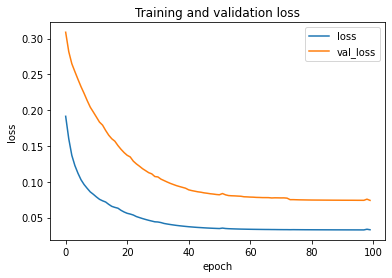

In [ ]:
# plot loss and val_loss
plt.figure()
loss_line, = plt.plot(history.epoch, history.history['loss'], label='loss')
val_loss_line, = plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(handles=[loss_line, val_loss_line])
plt.title('Training and validation loss')
plt.show()

## Prediction
- inverse transformation (for scaling) => sales difference
- calculate predicted sales: sales(t) = sales(t-1) + difference(t)

In [ ]:
# y_pred
y_pred = model.predict(x=X_valid, batch_size=1)
y_pred

array([[ 0.18105948],
       [-0.41710824],
       [-0.43948048],
       [-0.44925955],
       [ 0.19585568],
       [-0.44613975]], dtype=float32)

In [ ]:
y_valid

array([[ 0.56534894],
       [-0.59225685],
       [-0.34465072],
       [-0.12837125],
       [ 0.24765901],
       [-1.        ]])

### Inverse transformation

In [ ]:
# rebuild diff_pred: inverse y_pred
diff_pred = scaler_diff.inverse_transform(y_pred)
diff_pred

array([[  23192.77 ],
       [-106898.24 ],
       [-111763.81 ],
       [-113890.59 ],
       [  26410.684],
       [-113212.086]], dtype=float32)

### Calculate predicted sales

In [ ]:
sales_df[-7:]

,month,sales,sales_pred
53,2017-06-01,1064624,NaN
54,2017-07-01,1171393,1103042.0
55,2017-08-01,1026403,917708.0
56,2017-09-01,935263,805986.0
57,2017-10-01,891160,776183.0
58,2017-11-01,928837,779142.0
59,2017-12-01,695170,542891.0


In [ ]:
# creat result_df: dataframe that shows predcited sales for last 6 months
## method 1: current_sales = prev_actual_sales + diff_pred
# result_list = []
# month = sales_df.iloc[-7:]['month'].tolist()
# actual_sales = sales_df.iloc[-7:]['sales'].tolist()

# for i in range(0, len(diff_pred)):
#     result_dict = {}
#     result_dict['month'] = month[i+1]
#     result_dict['sales_pred'] = actual_sales[i] + int(diff_pred[i])
#     result_list.append(result_dict)

# result_df = pd.DataFrame(data=result_list)
# result_df

In [ ]:
## method 2: current_sales = last_sales + diff_pred
result_list = []
month = sales_df.iloc[-7:]['month'].tolist()
last_sales = sales_df.iloc[-7]['sales']

for i in range(0, len(diff_pred)):
    result_dict = {}
    result_dict['month'] = month[i+1]
    last_sales = last_sales + int(diff_pred[i])
    result_dict['sales_pred'] = last_sales
    result_list.append(result_dict)

result_df = pd.DataFrame(data=result_list)
result_df

,month,sales_pred
0,2017-07-01,1087816
1,2017-08-01,980918
2,2017-09-01,869155
3,2017-10-01,755265
4,2017-11-01,781675
5,2017-12-01,668463


In [ ]:
# sales_df.drop(['sales_pred_x', 'sales_pred_y'], axis=1, inplace=True)

In [ ]:
# merge with sales_df
sales_df = pd.merge(sales_df, result_df, how='left', on='month')
sales_df.tail(10)

,month,sales,sales_pred
50,2017-03-01,822667,NaN
51,2017-04-01,938862,NaN
52,2017-05-01,1020686,NaN
53,2017-06-01,1064624,NaN
54,2017-07-01,1171393,1087816.0
55,2017-08-01,1026403,980918.0
56,2017-09-01,935263,869155.0
57,2017-10-01,891160,755265.0
58,2017-11-01,928837,781675.0
59,2017-12-01,695170,668463.0


## Evaluation

In [ ]:
# rmse, mae, mape: predicted sales for last 6 months
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true=sales_df.iloc[-6:]['sales'], y_pred=sales_df.iloc[-6:]['sales_pred'])
print('rmse = {}'.format(np.sqrt(mse)))

mae = mean_absolute_error(y_true=sales_df.iloc[-6:]['sales'], y_pred=sales_df.iloc[-6:]['sales_pred'])
print('mae = {}'.format(mae))

mape = ((sales_df.iloc[-6:]['sales'] - sales_df.iloc[-6:]['sales_pred'])/sales_df.iloc[-6:]['sales']).mean()
print('mape = {}'.format(mape))

rmse = 95097.87671657029
mae = 84155.66666666667
mape = 0.08928237310427416


In [ ]:
# plot
plot_data = [
    go.Line(
        x=sales_df['month'],
        y=sales_df['sales'],
        name='actual'
    ),
    go.Line(
        x=sales_df['month'],
        y=sales_df['sales_pred'],
        name='predicted'
    )
]

plot_layout = go.Layout(
    title='Sales prediction'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

How to improve our model?
- add holidays, breaks
- add seasonal effects